## Claude's Attempt

In [2]:
# Cell 1

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [3]:
# Cell 2

# Load the pickle file
with open('../../../data/train/combined_train_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert to DataFrame if it's not already
if not isinstance(data, pd.DataFrame):
    df = pd.DataFrame(data)
else:
    df = data

print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes)
print(f"\nFirst few rows:")
print(df.head())
print(f"\nScore statistics:")
print(df['score'].describe())

Dataset shape: (175272, 11)

Column types:
accession         object
scoreset          object
ensp              object
pos                int64
ref_long          object
alt_long          object
score            float64
ref_embedding     object
alt_embedding     object
biotype           object
consequences      object
dtype: object

First few rows:
                    accession                 scoreset               ensp  \
0  urn:mavedb:00000069-a-2#24  urn:mavedb:00000069-a-2  ENSP00000252519.3   
1  urn:mavedb:00000069-a-2#25  urn:mavedb:00000069-a-2  ENSP00000252519.3   
2  urn:mavedb:00000069-a-2#26  urn:mavedb:00000069-a-2  ENSP00000252519.3   
3  urn:mavedb:00000069-a-2#27  urn:mavedb:00000069-a-2  ENSP00000252519.3   
4  urn:mavedb:00000069-a-2#28  urn:mavedb:00000069-a-2  ENSP00000252519.3   

   pos ref_long alt_long     score  \
0   76      Gln      Ter -1.822141   
1   75      Glu      Ter -1.841030   
2   74      Lys      Ter -2.129071   
3   73      Leu      Ter -1.624920  

In [4]:
# # Cell 2.1

# # Filter out extreme outliers MORE aggressively
# print(f"Original dataset size: {len(df)}")

# # Keep only values within a reasonable range (95th percentile and below)
# lower_percentile = df['score'].quantile(0.05)
# upper_percentile = df['score'].quantile(0.95)

# df_filtered = df[(df['score'] >= lower_percentile) & (df['score'] <= upper_percentile)].copy()

# print(f"Filtered dataset size: {len(df_filtered)}")
# print(f"Removed {len(df) - len(df_filtered)} outliers ({100*(len(df) - len(df_filtered))/len(df):.1f}%)")
# print(f"New score range: {df_filtered['score'].min():.4f} to {df_filtered['score'].max():.4f}")
# print(f"New score mean: {df_filtered['score'].mean():.4f}, std: {df_filtered['score'].std():.4f}")

# # Use filtered dataframe
# df = df_filtered

# # Filter only the most extreme outliers (keep 98% of data)
# print(f"Original dataset size: {len(df)}")

# # Keep values between 1st and 99th percentile
# lower_percentile = df['score'].quantile(0.01)
# upper_percentile = df['score'].quantile(0.99)

# df_filtered = df[(df['score'] >= lower_percentile) & (df['score'] <= upper_percentile)].copy()

# print(f"Filtered dataset size: {len(df_filtered)}")
# print(f"Removed {len(df) - len(df_filtered)} extreme outliers ({100*(len(df) - len(df_filtered))/len(df):.1f}%)")
# print(f"New score range: {df_filtered['score'].min():.4f} to {df_filtered['score'].max():.4f}")
# print(f"New score mean: {df_filtered['score'].mean():.4f}, std: {df_filtered['score'].std():.4f}")

# # Use filtered dataframe
# df = df_filtered

# NO FILTERING - use all data including extreme outliers
print(f"Using FULL unfiltered dataset: {len(df)} samples")
print(f"Score range: {df['score'].min():.4f} to {df['score'].max():.4f}")
print(f"Score mean: {df['score'].mean():.4f}, std: {df['score'].std():.4f}")
print(f"\nScore percentiles:")
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"  {p}th: {df['score'].quantile(p/100):.4f}")

Using FULL unfiltered dataset: 175272 samples
Score range: -47.9268 to 179.3154
Score mean: 0.7532, std: 4.6593

Score percentiles:
  1th: -1.7072
  5th: -0.9664
  25th: -0.3484
  50th: -0.0282
  75th: 0.6338
  95th: 7.5771
  99th: 9.9556


In [5]:
# Clean any corrupted embeddings in the dataset
print("Checking for corrupted embeddings...")
bad_indices = []

for idx in range(len(df)):
    ref_emb = df['ref_embedding'].iloc[idx]
    alt_emb = df['alt_embedding'].iloc[idx]
    
    # Convert to tensor to check
    if not isinstance(ref_emb, torch.Tensor):
        ref_emb = torch.tensor(ref_emb)
    if not isinstance(alt_emb, torch.Tensor):
        alt_emb = torch.tensor(alt_emb)
    
    # Check for NaN or Inf
    if torch.isnan(ref_emb).any() or torch.isinf(ref_emb).any():
        bad_indices.append(idx)
    elif torch.isnan(alt_emb).any() or torch.isinf(alt_emb).any():
        bad_indices.append(idx)

print(f"Found {len(bad_indices)} corrupted embeddings ({100*len(bad_indices)/len(df):.2f}%)")

if len(bad_indices) > 0:
    print(f"Removing corrupted entries...")
    df = df.drop(bad_indices).reset_index(drop=True)
    print(f"Clean dataset size: {len(df)}")

Checking for corrupted embeddings...


Found 2 corrupted embeddings (0.00%)
Removing corrupted entries...
Clean dataset size: 175270


In [6]:
# Cell 3

# Check the shape of embeddings
sample_ref_emb = df['ref_embedding'].iloc[0]
sample_alt_emb = df['alt_embedding'].iloc[0]

print(f"Reference embedding shape: {sample_ref_emb.shape}")
print(f"Alternative embedding shape: {sample_alt_emb.shape}")
print(f"Reference embedding type: {type(sample_ref_emb)}")

# Get embedding dimension
embedding_dim = sample_ref_emb.shape[0]
print(f"\nEmbedding dimension: {embedding_dim}")

Reference embedding shape: torch.Size([1152])
Alternative embedding shape: torch.Size([1152])
Reference embedding type: <class 'torch.Tensor'>

Embedding dimension: 1152


In [7]:
# Cell 3.1

# Let's see the actual score distribution
print("Raw score statistics:")
print(f"Min: {df['score'].min()}")
print(f"Max: {df['score'].max()}")
print(f"Mean: {df['score'].mean()}")
print(f"Std: {df['score'].std()}")
print(f"Median: {df['score'].median()}")

# Check for outliers
print(f"\nPercentiles:")
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"{p}th: {df['score'].quantile(p/100):.4f}")

Raw score statistics:
Min: -47.92682014
Max: 179.3154034
Mean: 0.75322806443028
Std: 4.659276162384374
Median: -0.028162083081479203

Percentiles:
1th: -1.7072
5th: -0.9663
25th: -0.3484
50th: -0.0282
75th: 0.6338
95th: 7.5771
99th: 9.9557


In [8]:
# Cell 3.2 – Build categorical feature mappings

# Categorical columns to use
cat_columns = ['accession', 'scoreset', 'ensp', 'ref_long', 'alt_long', 'biotype']

cat_maps = {}
for col in cat_columns:
    df[col] = df[col].astype(str)
    uniques = df[col].dropna().unique()
    cat_maps[col] = {val: idx for idx, val in enumerate(uniques)}
    print(f"Column '{col}' -> {len(uniques)} unique categories")

print("\nCategorical mappings created for:", cat_columns)


Column 'accession' -> 175270 unique categories
Column 'scoreset' -> 200 unique categories
Column 'ensp' -> 136 unique categories
Column 'ref_long' -> 20 unique categories
Column 'alt_long' -> 21 unique categories
Column 'biotype' -> 5 unique categories

Categorical mappings created for: ['accession', 'scoreset', 'ensp', 'ref_long', 'alt_long', 'biotype']


In [ ]:
# Cell 4

# from sklearn.preprocessing import MinMaxScaler

# class ProteinScoreDataset(Dataset):
#     def __init__(self, dataframe, score_scaler=None, fit_scaler=False):
#         self.df = dataframe.reset_index(drop=True)
        
#         # Use MinMaxScaler to scale to [0, 1] - more stable than StandardScaler
#         if fit_scaler:
#             self.score_scaler = MinMaxScaler(feature_range=(0, 1))
#             scores = self.df['score'].values.reshape(-1, 1)
#             self.score_scaler.fit(scores)
#         else:
#             self.score_scaler = score_scaler
            
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
        
#         # Get embeddings
#         ref_embedding = row['ref_embedding']
#         alt_embedding = row['alt_embedding']
        
#         # Ensure embeddings are torch tensors
#         if not isinstance(ref_embedding, torch.Tensor):
#             ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
#         else:
#             ref_embedding = ref_embedding.float()
            
#         if not isinstance(alt_embedding, torch.Tensor):
#             alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
#         else:
#             alt_embedding = alt_embedding.float()
        
#         # Concatenate embeddings
#         diff = alt_embedding - ref_embedding   ### CHANGED
#         abs_diff = torch.abs(diff)   ### CHANGED
#         combined_embedding = torch.cat([diff, abs_diff], dim=0)   ### CHANGED
        
#         # Normalize embeddings (L2 normalization)
#         norm = torch.norm(combined_embedding)
#         if norm > 0:
#             combined_embedding = combined_embedding / norm
        
#         # Get normalized score (will be in [0, 1] range)
#         score = self.score_scaler.transform([[row['score']]])[0][0]
#         score = torch.tensor(score, dtype=torch.float32)
        
#         return combined_embedding, score


# # ----- NEURAL NET ----- #

# from sklearn.preprocessing import RobustScaler

# class ProteinScoreDataset(Dataset):
#     def __init__(self, dataframe, score_scaler=None, fit_scaler=False):
#         self.df = dataframe.reset_index(drop=True)
        
#         # Calculate shift value to make all scores positive
#         self.score_shift = abs(self.df['score'].min()) + 1
        
#         # Use RobustScaler on LOG-TRANSFORMED scores
#         if fit_scaler:
#             self.score_scaler = RobustScaler()
#             # Log transform scores
#             scores_shifted = self.df['score'].values + self.score_shift
#             scores_log = np.log(scores_shifted)
#             self.score_scaler.fit(scores_log.reshape(-1, 1))
#         else:
#             self.score_scaler = score_scaler
            
#     def __len__(self):
#         return len(self.df)
    
    # def __getitem__(self, idx):
    #     row = self.df.iloc[idx]
        
    #     # Get embeddings
    #     ref_embedding = row['ref_embedding']
    #     alt_embedding = row['alt_embedding']
        
    #     # Ensure embeddings are torch tensors
    #     if not isinstance(ref_embedding, torch.Tensor):
    #         ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
    #     else:
    #         ref_embedding = ref_embedding.float()
            
    #     if not isinstance(alt_embedding, torch.Tensor):
    #         alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
    #     else:
    #         alt_embedding = alt_embedding.float()
        
    #     # USE DIFFERENCE instead of concatenation
    #     diff = alt_embedding - ref_embedding
    #     abs_diff = torch.abs(diff)
    #     combined_embedding = torch.cat([diff, abs_diff], dim=0)
        
    #     # Normalize the combined features
    #     norm = torch.norm(combined_embedding)
    #     if norm > 0:
    #         combined_embedding = combined_embedding / norm
        
    #     # Log transform and normalize score
    #     score_shifted = row['score'] + self.score_shift
    #     score_log = np.log(score_shifted)
    #     score_normalized = self.score_scaler.transform([[score_log]])[0][0]
    #     score = torch.tensor(score_normalized, dtype=torch.float32)
        
    #     return combined_embedding, score

    # def __getitem__(self, idx):
    #     row = self.df.iloc[idx]

    #     # ---- embeddings (numeric feature we can use immediately) ----
    #     ref_embedding = row["ref_embedding"]
    #     alt_embedding = row["alt_embedding"]

    #     if not isinstance(ref_embedding, torch.Tensor):
    #         ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
    #     else:
    #         ref_embedding = ref_embedding.float()

    #     if not isinstance(alt_embedding, torch.Tensor):
    #         alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
    #     else:
    #         alt_embedding = alt_embedding.float()

    #     # diff + |diff|, then L2-normalize
    #     diff = alt_embedding - ref_embedding
    #     abs_diff = torch.abs(diff)
    #     combined_embedding = torch.cat([diff, abs_diff], dim=0)
    #     norm = torch.norm(combined_embedding)
    #     if norm > 0:
    #         combined_embedding = combined_embedding / norm

    #     # ---- target (same normalization you already had) ----
    #     score_shifted = row["score"] + self.score_shift
    #     score_log = np.log(score_shifted)
    #     score_normalized = self.score_scaler.transform([[score_log]])[0][0]
    #     score = torch.tensor(score_normalized, dtype=torch.float32)

    #     # ---- pack ALL other columns; keep raw so you can encode later ----
    #     features = {
    #         # numeric tensor you can feed straight into a model head
    #         "X": combined_embedding,                    # torch.FloatTensor [2*D]

    #         # raw meta / categorical fields (encode later)
    #         "accession": str(row["accession"]),
    #         "scoreset":  str(row["scoreset"]),
    #         "ensp":      str(row["ensp"]),
    #         "pos":       torch.tensor(int(row["pos"]), dtype=torch.float32),  # keep as tensor
    #         "ref_long":  str(row["ref_long"]),
    #         "alt_long":  str(row["alt_long"]),
    #         "biotype":   str(row["biotype"]),
    #         # list[str]; default collate will give you a list-of-lists per batch
    #         "consequence": list(row["consequence"]) if isinstance(row["consequence"], (list, tuple))
    #                     else ([row["consequence"]] if row["consequence"] is not None else []),
    #     }

    #     # Return a (features, target) pair; DataLoader can collate dicts by key.
    #     return features, score

    
    # def inverse_transform_score(self, normalized_scores):
    #     """Convert normalized log scores back to original scale"""
    #     # Input: normalized log-transformed scores
    #     # Output: original scale scores
        
    #     normalized_scores = np.array(normalized_scores).reshape(-1, 1)
        
    #     # Step 1: Inverse normalize
    #     scores_log = self.score_scaler.inverse_transform(normalized_scores)
        
    #     # Step 2: Inverse log transform
    #     scores_shifted = np.exp(scores_log)
        
    #     # Step 3: Remove shift
    #     scores_original = scores_shifted - self.score_shift
        
    #     return scores_original.flatten()

# Cell 4 – Dataset with full feature vector (embeddings + other columns)

from sklearn.preprocessing import RobustScaler

class ProteinScoreDataset(Dataset):
    def __init__(self, dataframe, score_scaler=None, fit_scaler=False,
                 cat_columns=None, cat_maps=None):
        self.df = dataframe.reset_index(drop=True)
        self.cat_columns = cat_columns or []
        self.cat_maps = cat_maps or {}

        # Shift to make all scores positive
        self.score_shift = abs(self.df['score'].min()) + 1

        # RobustScaler on LOG-transformed scores
        if fit_scaler:
            self.score_scaler = RobustScaler()
            scores_shifted = self.df['score'].values + self.score_shift
            scores_log = np.log(scores_shifted)
            self.score_scaler.fit(scores_log.reshape(-1, 1))
        else:
            self.score_scaler = score_scaler

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ---- Embeddings ----
        ref_embedding = row["ref_embedding"]
        alt_embedding = row["alt_embedding"]

        if not isinstance(ref_embedding, torch.Tensor):
            ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
        else:
            ref_embedding = ref_embedding.float()

        if not isinstance(alt_embedding, torch.Tensor):
            alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
        else:
            alt_embedding = alt_embedding.float()

        # diff + |diff|, then L2-normalize
        diff = alt_embedding - ref_embedding
        abs_diff = torch.abs(diff)
        combined_embedding = torch.cat([diff, abs_diff], dim=0)   # [2*D]

        norm = torch.norm(combined_embedding)
        if norm > 0:
            combined_embedding = combined_embedding / norm

        # ---- Extra features: categorical + pos ----
        cat_feats = []
        for col in self.cat_columns:
            val = str(row[col])
            mapping = self.cat_maps.get(col, {})
            cat_feats.append(mapping.get(val, -1))  # -1 for unseen

        pos_val = row['pos']
        if pd.isna(pos_val) or np.isinf(pos_val):
            pos_val = -1
        extra_features = torch.tensor(cat_feats + [float(pos_val)],
                                      dtype=torch.float32)        # [len(cat_columns)+1]

        # Final input vector: [2*D + len(cat_columns) + 1]
        X = torch.cat([combined_embedding, extra_features], dim=0)

        # ---- Target (log + RobustScaler) ----
        score_shifted = row["score"] + self.score_shift
        score_log = np.log(score_shifted)
        score_normalized = self.score_scaler.transform([[score_log]])[0][0]
        y = torch.tensor(score_normalized, dtype=torch.float32)

        return X, y

    def inverse_transform_score(self, normalized_scores):
        """Convert normalized log scores back to original scale."""
        normalized_scores = np.array(normalized_scores).reshape(-1, 1)

        # Inverse RobustScaler
        scores_log = self.score_scaler.inverse_transform(normalized_scores)

        # Inverse log
        scores_shifted = np.exp(scores_log)

        # Remove shift
        scores_original = scores_shifted - self.score_shift

        return scores_original.flatten()


IndentationError: expected an indented block after function definition on line 212 (497412476.py, line 216)

In [25]:
# # Cell 5

# # Split data into train and validation sets
# train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# print(f"Training set size: {len(train_df)}")
# print(f"Validation set size: {len(val_df)}")

# # Create datasets with normalization
# train_dataset = ProteinScoreDataset(train_df, fit_scaler=True)
# val_dataset = ProteinScoreDataset(val_df, score_scaler=train_dataset.score_scaler, fit_scaler=False)

# # Create dataloaders
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# print(f"\nScore normalization (RobustScaler):")
# print(f"  Center: {train_dataset.score_scaler.center_[0]:.4f}")
# print(f"  Scale: {train_dataset.score_scaler.scale_[0]:.4f}")

# Cell 5

# Split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create datasets with normalization + extra features
train_dataset = ProteinScoreDataset(
    train_df,
    fit_scaler=True,
    cat_columns=cat_columns,
    cat_maps=cat_maps
)

val_dataset = ProteinScoreDataset(
    val_df,
    score_scaler=train_dataset.score_scaler,
    fit_scaler=False,
    cat_columns=cat_columns,
    cat_maps=cat_maps
)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nScore normalization (RobustScaler):")
print(f"  Center: {train_dataset.score_scaler.center_[0]:.4f}")
print(f"  Scale:  {train_dataset.score_scaler.scale_[0]:.4f}")


Training set size: 140216
Validation set size: 35054

Score normalization (RobustScaler):
  Center: 3.8897
  Scale:  0.0201


In [11]:

# Cell 6

# class ScorePredictionNet(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.1):
#         super(ScorePredictionNet, self).__init__()
        
#         self.layers = nn.ModuleList()
#         prev_dim = input_dim
        
#         # Build hidden layers
#         for hidden_dim in hidden_dims:
#             self.layers.append(nn.Linear(prev_dim, hidden_dim))
#             self.layers.append(nn.LayerNorm(hidden_dim))  # LayerNorm instead of BatchNorm
#             self.layers.append(nn.Tanh())  # Tanh instead of ReLU - bounded output
#             self.layers.append(nn.Dropout(dropout_rate))
#             prev_dim = hidden_dim
        
#         # Output layer
#         self.output = nn.Linear(prev_dim, 1)
#         self.sigmoid = nn.Sigmoid()  # Sigmoid to ensure [0, 1] output
        
#         # Initialize weights conservatively
#         for layer in self.layers:
#             if isinstance(layer, nn.Linear):
#                 nn.init.xavier_uniform_(layer.weight, gain=0.1)
#                 nn.init.zeros_(layer.bias)
        
#         nn.init.xavier_uniform_(self.output.weight, gain=0.01)
#         nn.init.zeros_(self.output.bias)
        
#     def forward(self, x):
#         for layer in self.layers:
#             x = layer(x)
        
#         x = self.output(x)
#         x = self.sigmoid(x)
        
#         return x.squeeze()

# # Initialize model
# input_dim = embedding_dim * 2
# model = ScorePredictionNet(input_dim)

# # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# print(f"Using device: {device}")
# print(f"\nModel architecture:")
# print(model)
# print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


# ----- NEURAL NET ----- #

# # In Cell 6, modify the model:
# class ScorePredictionNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.2):
#         super(ScorePredictionNet, self).__init__()
        
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_dim, 1)
        
#         # Add a learnable global bias term
#         self.global_bias = nn.Parameter(torch.zeros(1))
        
#         # ... initialization ...
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = torch.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x) + self.global_bias  # Add global bias
#         return x.squeeze()

# # Initialize model
# input_dim = embedding_dim * 2  # diff + abs_diff
# model = ScorePredictionNet(input_dim, hidden_dim=128)  # Changed from 64

# # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# print(f"Using device: {device}")
# print(f"\nModel architecture:")
# print(model)
# print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Cell 6 – model with expanded input dim

class ScorePredictionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.2):
        super(ScorePredictionNet, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # Learnable global bias
        self.global_bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x) + self.global_bias
        return x.squeeze()

# New input_dim: embeddings (2*D) + categorical + pos
input_dim = embedding_dim * 2 + len(cat_columns) + 1

model = ScorePredictionNet(input_dim, hidden_dim=128)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Using device: {device}")
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cpu

Model architecture:
ScorePredictionNet(
  (fc1): Linear(in_features=2311, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

Total parameters: 296,322


In [12]:
# Cell 7

# # Training hyperparameters
# learning_rate = 0.0001  # Can be slightly higher with [0,1] range
# num_epochs = 100
# patience = 15

# # MSE is fine for [0, 1] range
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# # Learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=5
# )

# print(f"Learning rate: {learning_rate}")
# print(f"Number of epochs: {num_epochs}")
# print(f"Loss function: MSE (scores in [0, 1] range)")

# ----- NEURAL NET ----- #

# Training hyperparameters
learning_rate = 0.001
num_epochs = 3
patience = 15

# Huber Loss - robust to outliers
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Loss function: Huber Loss (robust to outliers)")
print(f"Score transformation: Log transform + RobustScaler")

Learning rate: 0.001
Number of epochs: 3
Loss function: Huber Loss (robust to outliers)
Score transformation: Log transform + RobustScaler


In [13]:
# Cell 7.1

# Test a single batch to see where NaN originates
model.eval()
train_iter = iter(train_loader)
embeddings, scores = next(train_iter)

print("=" * 50)
print("DEBUGGING NaN ISSUE")
print("=" * 50)

# Check input data
print(f"\n1. INPUT DATA CHECK:")
print(f"   Embeddings shape: {embeddings.shape}")
print(f"   Embeddings contain NaN: {torch.isnan(embeddings).any()}")
print(f"   Embeddings contain Inf: {torch.isinf(embeddings).any()}")
print(f"   Embeddings min: {embeddings.min():.4f}, max: {embeddings.max():.4f}")
print(f"   Embeddings mean: {embeddings.mean():.4f}, std: {embeddings.std():.4f}")

print(f"\n   Scores shape: {scores.shape}")
print(f"   Scores contain NaN: {torch.isnan(scores).any()}")
print(f"   Scores contain Inf: {torch.isinf(scores).any()}")
print(f"   Scores min: {scores.min():.4f}, max: {scores.max():.4f}")
print(f"   Scores mean: {scores.mean():.4f}, std: {scores.std():.4f}")

# Check model forward pass
embeddings = embeddings.to(device)
scores = scores.to(device)

with torch.no_grad():
    predictions = model(embeddings)
    
print(f"\n2. MODEL OUTPUT CHECK:")
print(f"   Predictions contain NaN: {torch.isnan(predictions).any()}")
print(f"   Predictions contain Inf: {torch.isinf(predictions).any()}")
if not torch.isnan(predictions).any():
    print(f"   Predictions min: {predictions.min():.4f}, max: {predictions.max():.4f}")
    print(f"   Predictions mean: {predictions.mean():.4f}, std: {predictions.std():.4f}")

# Check loss calculation
loss = criterion(predictions, scores)
print(f"\n3. LOSS CHECK:")
print(f"   Loss value: {loss.item()}")
print(f"   Loss is NaN: {torch.isnan(loss)}")

# Check model weights
print(f"\n4. MODEL WEIGHTS CHECK:")
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"   NaN found in {name}")
    if torch.isinf(param).any():
        print(f"   Inf found in {name}")
    print(f"   {name}: min={param.min():.4f}, max={param.max():.4f}, mean={param.abs().mean():.4f}")
    if len(list(model.named_parameters())) > 10:  # Only print first few if many layers
        break

print("=" * 50)

DEBUGGING NaN ISSUE

1. INPUT DATA CHECK:
   Embeddings shape: torch.Size([64, 2311])
   Embeddings contain NaN: False
   Embeddings contain Inf: False
   Embeddings min: -0.4029, max: 173581.0000
   Embeddings mean: 35.0884, std: 1986.9869

   Scores shape: torch.Size([64])
   Scores contain NaN: False
   Scores contain Inf: False
   Scores min: -1.0786, max: 9.2649
   Scores mean: 0.7752, std: 2.5759

2. MODEL OUTPUT CHECK:
   Predictions contain NaN: False
   Predictions contain Inf: False
   Predictions min: -62.9149, max: -1.5470
   Predictions mean: -29.3454, std: 18.5030

3. LOSS CHECK:
   Loss value: 29.620574951171875
   Loss is NaN: False

4. MODEL WEIGHTS CHECK:
   global_bias: min=0.0000, max=0.0000, mean=0.0000
   fc1.weight: min=-0.0208, max=0.0208, mean=0.0104
   fc1.bias: min=-0.0208, max=0.0208, mean=0.0092
   bn1.weight: min=1.0000, max=1.0000, mean=1.0000
   bn1.bias: min=0.0000, max=0.0000, mean=0.0000
   fc2.weight: min=-0.0876, max=0.0875, mean=0.0429
   fc2.bias:

In [14]:
# Cell 8

# Training history
train_losses = []
val_losses = []
train_losses_denorm = []
val_losses_denorm = []
best_val_loss = float('inf')
patience_counter = 0

print("Starting training...\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    all_train_preds = []
    all_train_targets = []
    
    for embeddings, scores in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        embeddings = embeddings.to(device)
        scores = scores.to(device)
        
        # Check for NaN in inputs BEFORE forward pass
        if torch.isnan(embeddings).any() or torch.isinf(embeddings).any():
            print(f"\n⚠️  NaN/Inf in embeddings at batch {train_batches}, skipping...")
            continue
        
        if torch.isnan(scores).any() or torch.isinf(scores).any():
            print(f"\n⚠️  NaN/Inf in scores at batch {train_batches}, skipping...")
            continue
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(embeddings)
        
        # Check predictions before loss
        if torch.isnan(predictions).any() or torch.isinf(predictions).any():
            print(f"\n⚠️  NaN/Inf in predictions at batch {train_batches}, skipping...")
            continue
        
        loss = criterion(predictions, scores)
        
        # Check for NaN loss before backward
        if torch.isnan(loss):
            print(f"\n⚠️  NaN loss detected at epoch {epoch+1}, batch {train_batches}")
            continue
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        
        # Store for denormalized metrics
        all_train_preds.extend(predictions.detach().cpu().numpy())
        all_train_targets.extend(scores.cpu().numpy())
    
    if train_batches == 0:
        print("All batches had NaN loss. Stopping training.")
        break
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # Calculate denormalized train MSE
    train_preds_denorm = train_dataset.inverse_transform_score(all_train_preds)
    train_targets_denorm = train_dataset.score_scaler.inverse_transform(
        np.array(all_train_targets).reshape(-1, 1)
    ).flatten()
    train_mse_denorm = mean_squared_error(train_targets_denorm, train_preds_denorm)
    train_losses_denorm.append(train_mse_denorm)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    all_val_preds = []
    all_val_targets = []
    
    with torch.no_grad():
        for embeddings, scores in val_loader:
            embeddings = embeddings.to(device)
            scores = scores.to(device)
            
            # Skip batches with NaN
            if torch.isnan(embeddings).any() or torch.isnan(scores).any():
                continue
            
            predictions = model(embeddings)
            
            if torch.isnan(predictions).any():
                continue
            
            loss = criterion(predictions, scores)
            
            if not torch.isnan(loss):
                val_loss += loss.item()
                val_batches += 1
                
                # Store for denormalized metrics
                all_val_preds.extend(predictions.cpu().numpy())
                all_val_targets.extend(scores.cpu().numpy())
    
    if val_batches == 0:
        print("All validation batches had NaN loss. Stopping training.")
        break
        
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Calculate denormalized val MSE
    val_preds_denorm = train_dataset.inverse_transform_score(all_val_preds)
    val_targets_denorm = train_dataset.inverse_transform_score(all_val_targets)
    val_targets_denorm = train_dataset.score_scaler.inverse_transform(
        np.array(all_val_targets).reshape(-1, 1)
    ).flatten()
    val_mse_denorm = mean_squared_error(val_targets_denorm, val_preds_denorm)
    val_losses_denorm.append(val_mse_denorm)
    
    # Update learning rate scheduler
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Normalized   - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"  Denormalized - Train MSE: {train_mse_denorm:.4f}, Val MSE: {val_mse_denorm:.4f}")
    
    # Early stopping based on denormalized validation MSE
    if val_mse_denorm < best_val_loss:
        best_val_loss = val_mse_denorm
        patience_counter = 0
        print(f"  → New best model! (Val MSE: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

print("\nTraining completed!")
print(f"Best validation MSE (denormalized): {best_val_loss:.4f}")

Starting training...



Epoch 1/3 [Train]: 100%|██████████| 2191/2191 [00:35<00:00, 61.23it/s]


Epoch 1/3
  Normalized   - Train Loss: 0.8592, Val Loss: 9.0057
  Denormalized - Train MSE: 14.0822, Val MSE: 11.5291
  → New best model! (Val MSE: 11.5291)


Epoch 2/3 [Train]: 100%|██████████| 2191/2191 [00:34<00:00, 63.76it/s]


Epoch 2/3
  Normalized   - Train Loss: 0.8432, Val Loss: 8.8664
  Denormalized - Train MSE: 14.0880, Val MSE: 12.5500


Epoch 3/3 [Train]: 100%|██████████| 2191/2191 [00:34<00:00, 63.53it/s]


Epoch 3/3
  Normalized   - Train Loss: 0.8416, Val Loss: 8.8308
  Denormalized - Train MSE: 14.0626, Val MSE: 12.7508

Training completed!
Best validation MSE (denormalized): 11.5291


In [15]:
# Cell 9

# Model is already trained, just set to eval mode
model.eval()

# Get predictions for validation set
val_predictions = []
val_actuals = []
val_predictions_normalized = []
val_actuals_normalized = []

with torch.no_grad():
    for embeddings, scores in val_loader:
        embeddings = embeddings.to(device)
        scores_normalized = scores.to(device)
        predictions_normalized = model(embeddings)
        
        # Store normalized predictions and actuals
        val_predictions_normalized.extend(predictions_normalized.cpu().numpy())
        val_actuals_normalized.extend(scores_normalized.cpu().numpy())

# Convert to arrays
val_predictions_normalized = np.array(val_predictions_normalized).reshape(-1, 1)
val_actuals_normalized = np.array(val_actuals_normalized).reshape(-1, 1)

# Inverse transform to get original scale
val_predictions = train_dataset.inverse_transform_score(val_predictions_normalized)
val_actuals = train_dataset.inverse_transform_score(val_actuals_normalized)

# Calculate metrics on original scale
mse = mean_squared_error(val_actuals, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actuals, val_predictions)
r2 = r2_score(val_actuals, val_predictions)

print("=" * 50)
print("VALIDATION SET RESULTS (Original Scale)")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)

# Also show normalized metrics for reference
mse_norm = mean_squared_error(val_actuals_normalized, val_predictions_normalized)
print(f"\nNormalized MSE: {mse_norm:.4f}")

VALIDATION SET RESULTS (Original Scale)
Mean Squared Error (MSE):  87.1635
Root Mean Squared Error (RMSE): 9.3361
Mean Absolute Error (MAE): 8.3779
R² Score: -2.7829

Normalized MSE: 100.2206


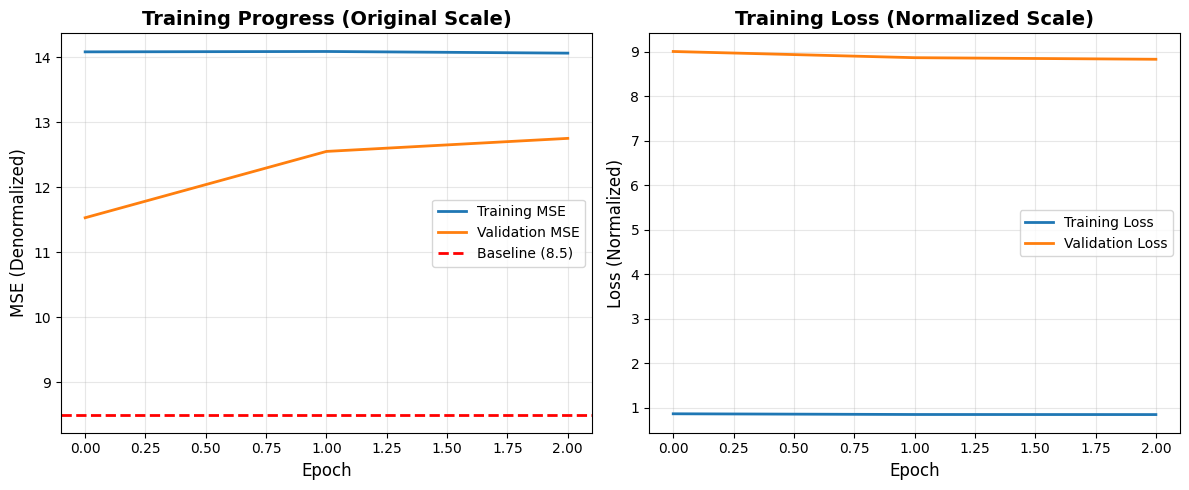

In [16]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_denorm, label='Training MSE', linewidth=2)
plt.plot(val_losses_denorm, label='Validation MSE', linewidth=2)
plt.axhline(y=8.5, color='r', linestyle='--', label='Baseline (8.5)', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE (Denormalized)', fontsize=12)
plt.title('Training Progress (Original Scale)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Normalized)', fontsize=12)
plt.title('Training Loss (Normalized Scale)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../../output/training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

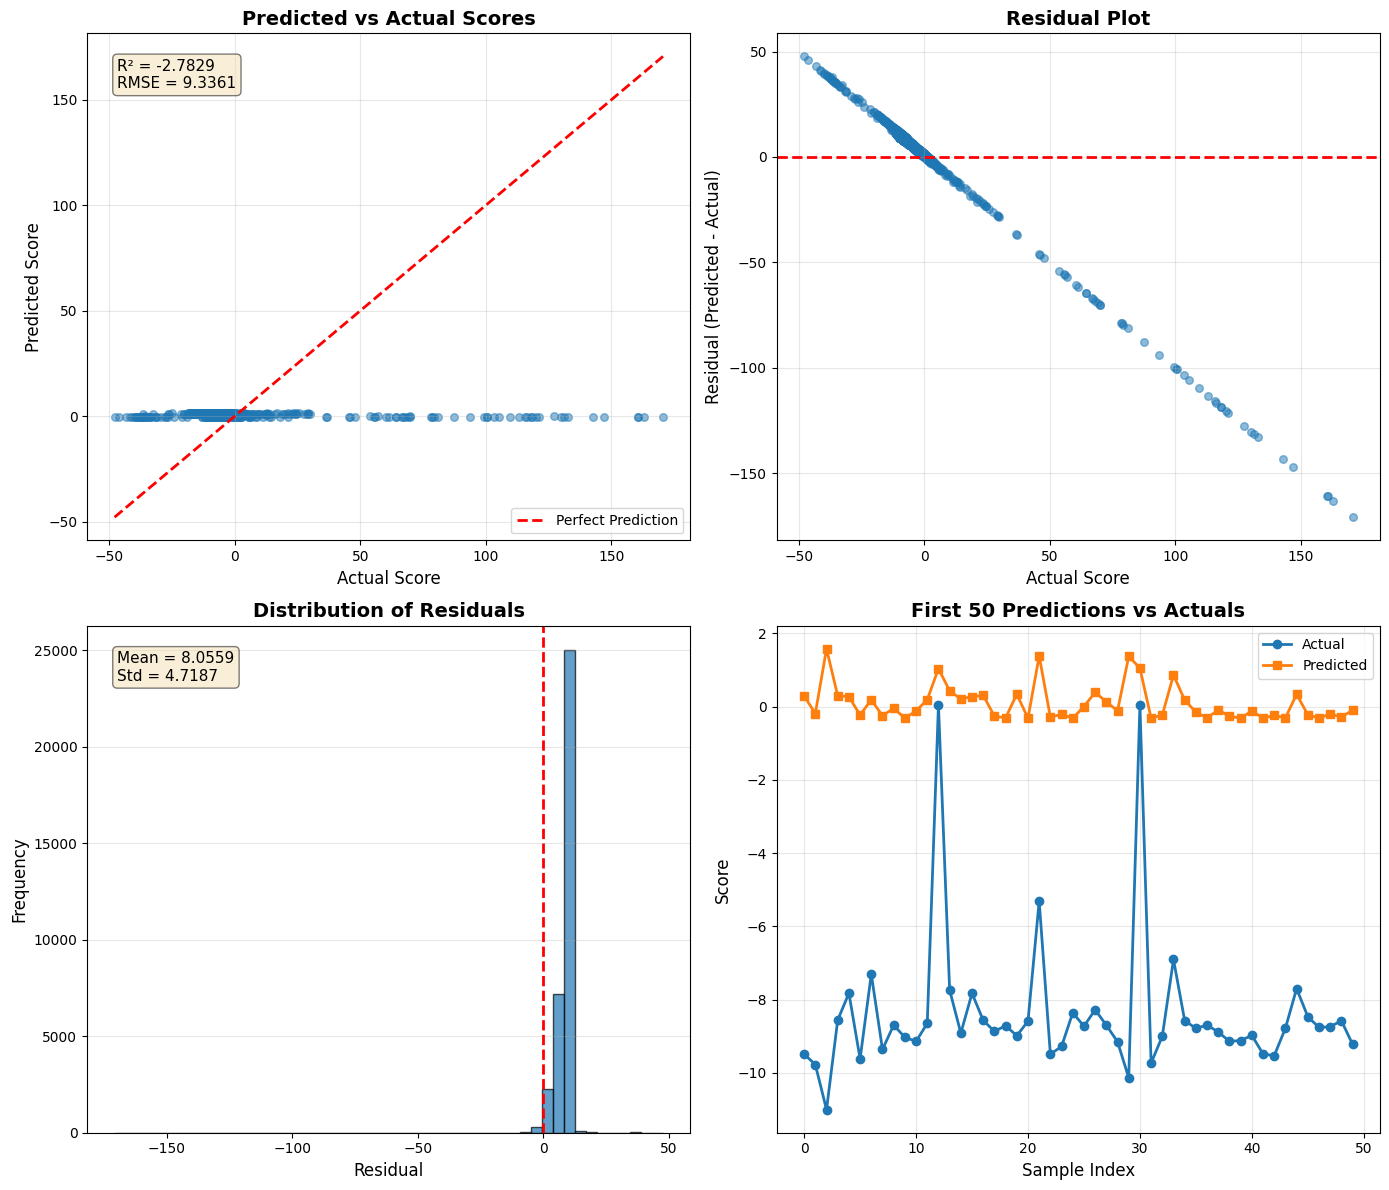


Visualizations saved to ../output/


In [17]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Scatter plot: Predicted vs Actual
ax1 = axes[0, 0]
ax1.scatter(val_actuals, val_predictions, alpha=0.5, s=30)
ax1.plot([val_actuals.min(), val_actuals.max()], 
         [val_actuals.min(), val_actuals.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Score', fontsize=12)
ax1.set_ylabel('Predicted Score', fontsize=12)
ax1.set_title('Predicted vs Actual Scores', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.4f}', 
         transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residual plot
ax2 = axes[0, 1]
residuals = val_predictions - val_actuals
ax2.scatter(val_actuals, residuals, alpha=0.5, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Actual Score', fontsize=12)
ax2.set_ylabel('Residual (Predicted - Actual)', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Distribution of residuals
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residual', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.text(0.05, 0.95, f'Mean = {residuals.mean():.4f}\nStd = {residuals.std():.4f}', 
         transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Comparison of first N predictions
ax4 = axes[1, 1]
n_samples = min(50, len(val_actuals))
indices = np.arange(n_samples)
ax4.plot(indices, val_actuals[:n_samples], 'o-', label='Actual', linewidth=2, markersize=6)
ax4.plot(indices, val_predictions[:n_samples], 's-', label='Predicted', linewidth=2, markersize=6)
ax4.set_xlabel('Sample Index', fontsize=12)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title(f'First {n_samples} Predictions vs Actuals', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualizations saved to ../output/")

In [18]:
# Error analysis on DENORMALIZED scale
errors = np.abs(residuals)
percentiles = [50, 75, 90, 95, 99]

print("\n" + "=" * 50)
print("ERROR ANALYSIS (DENORMALIZED SCALE)")
print("=" * 50)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Median Absolute Error: {np.median(errors):.4f}")
print(f"Max Absolute Error: {np.max(errors):.4f}")
print(f"\nError Percentiles:")
for p in percentiles:
    print(f"  {p}th percentile: {np.percentile(errors, p):.4f}")

# Find worst predictions
worst_indices = np.argsort(errors)[-10:][::-1]
print(f"\n{'=' * 50}")
print("TOP 10 WORST PREDICTIONS (DENORMALIZED)")
print("=" * 50)
print(f"{'Index':<8} {'Actual':<12} {'Predicted':<12} {'Error':<12}")
print("-" * 50)
for idx in worst_indices:
    print(f"{idx:<8} {val_actuals[idx]:<12.4f} {val_predictions[idx]:<12.4f} {errors[idx]:<12.4f}")

print(f"\n{'=' * 50}")
print("COMPARISON TO BASELINE")
print("=" * 50)
print(f"Baseline MSE:        8.5000")
print(f"Your Model MSE:      {mse:.4f}")
if mse < 8.5:
    improvement = ((8.5 - mse) / 8.5) * 100
    print(f"Improvement:         {improvement:.1f}% better! 🎉")
else:
    worse = ((mse - 8.5) / 8.5) * 100
    print(f"Performance:         {worse:.1f}% worse")
print("=" * 50)


ERROR ANALYSIS (DENORMALIZED SCALE)
Mean Absolute Error: 8.3779
Median Absolute Error: 8.6430
Max Absolute Error: 170.8411

Error Percentiles:
  50th percentile: 8.6430
  75th percentile: 9.0663
  90th percentile: 9.4417
  95th percentile: 9.8235
  99th percentile: 11.8231

TOP 10 WORST PREDICTIONS (DENORMALIZED)
Index    Actual       Predicted    Error       
--------------------------------------------------
10124    170.6575     -0.1836      170.8411    
30676    162.8936     -0.2264      163.1200    
29635    160.7049     -0.2106      160.9154    
12197    160.4900     -0.2125      160.7025    
21866    146.9449     -0.2038      147.1488    
10512    142.8777     -0.2088      143.0866    
34816    132.8357     -0.1820      133.0177    
30901    131.2587     -0.1715      131.4302    
17591    130.1391     -0.2099      130.3490    
23967    127.2643     -0.1524      127.4167    

COMPARISON TO BASELINE
Baseline MSE:        8.5000
Your Model MSE:      87.1635
Performance:         925

OFFSET ANALYSIS
Current MSE (no offset):     87.1635
Best offset:                 -8.0000
MSE with best offset:        22.2694
Improvement:                 64.8941

Mean prediction bias:        8.0559
(Predictions are on average 8.06 units higher than actuals)


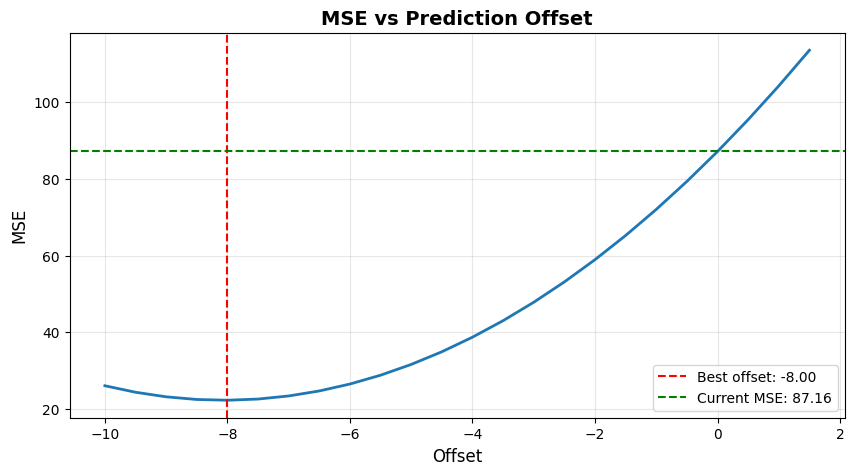

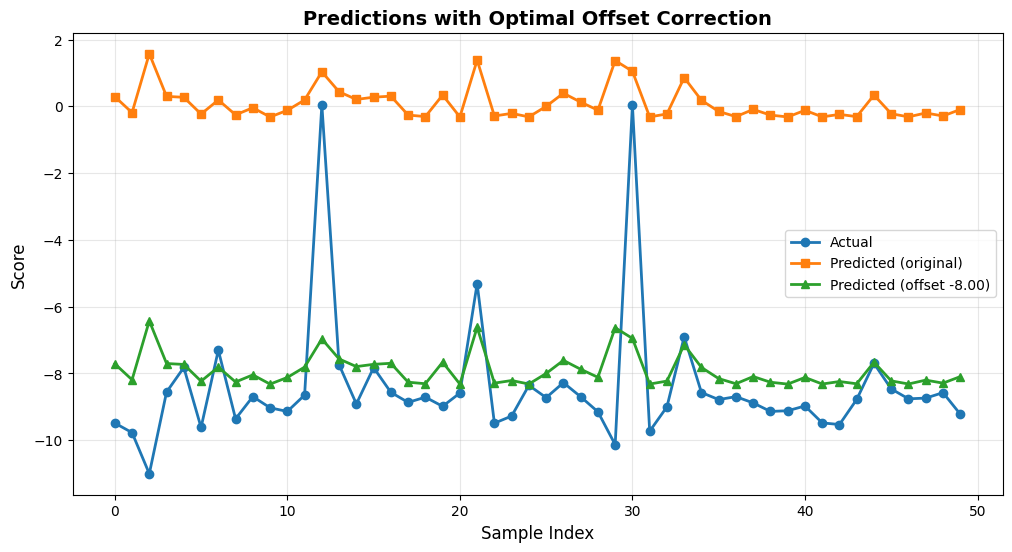

In [19]:
# -------- TEMP BLOCK -------- #

# Calculate optimal offset and MSE with correction
offsets_to_test = np.arange(-10, 2, 0.5)  # Test offsets from -10 to +2
mses = []

for offset in offsets_to_test:
    adjusted_predictions = val_predictions + offset
    mse_adjusted = mean_squared_error(val_actuals, adjusted_predictions)
    mses.append(mse_adjusted)

# Find best offset
best_idx = np.argmin(mses)
best_offset = offsets_to_test[best_idx]
best_mse = mses[best_idx]

print("=" * 50)
print("OFFSET ANALYSIS")
print("=" * 50)
print(f"Current MSE (no offset):     {mse:.4f}")
print(f"Best offset:                 {best_offset:.4f}")
print(f"MSE with best offset:        {best_mse:.4f}")
print(f"Improvement:                 {mse - best_mse:.4f}")
print("=" * 50)

# Calculate simple mean offset
mean_offset = (val_predictions - val_actuals).mean()
print(f"\nMean prediction bias:        {mean_offset:.4f}")
print(f"(Predictions are on average {abs(mean_offset):.2f} units {'higher' if mean_offset > 0 else 'lower'} than actuals)")

# Plot MSE vs offset
plt.figure(figsize=(10, 5))
plt.plot(offsets_to_test, mses, linewidth=2)
plt.axvline(x=best_offset, color='r', linestyle='--', label=f'Best offset: {best_offset:.2f}')
plt.axhline(y=mse, color='g', linestyle='--', label=f'Current MSE: {mse:.2f}')
plt.xlabel('Offset', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE vs Prediction Offset', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show corrected predictions
val_predictions_corrected = val_predictions + best_offset

plt.figure(figsize=(12, 6))
plt.plot(val_actuals[:50], 'o-', label='Actual', linewidth=2, markersize=6)
plt.plot(val_predictions[:50], 's-', label='Predicted (original)', linewidth=2, markersize=6)
plt.plot(val_predictions_corrected[:50], '^-', label=f'Predicted (offset {best_offset:.2f})', linewidth=2, markersize=6)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Predictions with Optimal Offset Correction', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# Code to generate file to submit to kaggle

# data at ../../../data/test/combined_test_data.pkl

# Load test data
print("Loading test data...")
with open('../../../data/test/combined_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# Convert to DataFrame if needed
if not isinstance(test_data, pd.DataFrame):
    test_df = pd.DataFrame(test_data)
else:
    test_df = test_data

print(f"Test dataset shape: {test_df.shape}")
print(f"Test columns: {test_df.columns.tolist()}")

# Create test dataset (no scores, so we'll pass dummy scores)
# class TestProteinScoreDataset(Dataset):
#     def __init__(self, dataframe, score_scaler):
#         self.df = dataframe.reset_index(drop=True)
#         self.score_scaler = score_scaler
        
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
        
#         # Get embeddings
#         ref_embedding = row['ref_embedding']
#         alt_embedding = row['alt_embedding']
        
#         # Ensure embeddings are torch tensors
#         if not isinstance(ref_embedding, torch.Tensor):
#             ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
#         else:
#             ref_embedding = ref_embedding.float()
            
#         if not isinstance(alt_embedding, torch.Tensor):
#             alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
#         else:
#             alt_embedding = alt_embedding.float()
        
#         # Concatenate embeddings
#         combined_embedding = torch.cat([ref_embedding, alt_embedding], dim=0)
        
#         # Normalize embeddings (L2 normalization)
#         norm = torch.norm(combined_embedding)
#         if norm > 0:
#             combined_embedding = combined_embedding / norm
        
#         return combined_embedding, row['accession']

# class TestProteinScoreDataset(Dataset):
#     def __init__(self, dataframe, score_scaler):
#         self.df = dataframe.reset_index(drop=True)
#         self.score_scaler = score_scaler
        
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
        
#         # Get embeddings
#         ref_embedding = row['ref_embedding']
#         alt_embedding = row['alt_embedding']
        
#         # Ensure embeddings are torch tensors
#         if not isinstance(ref_embedding, torch.Tensor):
#             ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
#         else:
#             ref_embedding = ref_embedding.float()
            
#         if not isinstance(alt_embedding, torch.Tensor):
#             alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
#         else:
#             alt_embedding = alt_embedding.float()
        
#         # USE SAME DIFFERENCE APPROACH
#         diff = alt_embedding - ref_embedding
#         abs_diff = torch.abs(diff)
#         combined_embedding = torch.cat([diff, abs_diff], dim=0)
        
#         # Normalize
#         norm = torch.norm(combined_embedding)
#         if norm > 0:
#             combined_embedding = combined_embedding / norm
        
#         return combined_embedding, row['accession']

# # Create test dataset and dataloader
# test_dataset = TestProteinScoreDataset(test_df, train_dataset.score_scaler)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# print(f"\nGenerating predictions for {len(test_df)} test samples...")

# # Generate predictions
# model.eval()
# predictions_normalized = []
# accessions = []

# with torch.no_grad():
#     for embeddings, batch_accessions in tqdm(test_loader, desc="Predicting"):
#         embeddings = embeddings.to(device)
        
#         # Skip if NaN in embeddings
#         if torch.isnan(embeddings).any() or torch.isinf(embeddings).any():
#             # Use median prediction for problematic samples
#             preds = torch.full((embeddings.size(0),), 0.5, device=device)
#         else:
#             preds = model(embeddings)
            
#             # Replace any NaN predictions with median
#             if torch.isnan(preds).any():
#                 preds = torch.where(torch.isnan(preds), torch.tensor(0.5, device=device), preds)
        
#         predictions_normalized.extend(preds.cpu().numpy())
#         accessions.extend(batch_accessions)

# # Convert to array and denormalize
# predictions_normalized = np.array(predictions_normalized).reshape(-1, 1)
# # In the test prediction loop, use the same Dataset class
# # Then at the end:
# predictions_denormalized = train_dataset.inverse_transform_score(all_predictions)

# # Create submission dataframe with exact format from example
# submission_df = pd.DataFrame({
#     'accession': accessions,
#     'score': predictions_denormalized  # Second column with empty header name
# })

# # Save to CSV
# output_path = './output.csv'
# submission_df.to_csv(output_path, index=False)

# print(f"\n✓ Predictions saved to {output_path}")
# print(f"\nSubmission file preview:")
# print(submission_df.head(10))
# print(f"\nPrediction statistics:")
# print(f"Min: {predictions_denormalized.min():.4f}")
# print(f"Max: {predictions_denormalized.max():.4f}")
# print(f"Mean: {predictions_denormalized.mean():.4f}")
# print(f"Median: {np.median(predictions_denormalized):.4f}")

# Test dataset using the SAME feature construction as training

class TestProteinScoreDataset(Dataset):
    def __init__(self, dataframe, cat_columns, cat_maps):
        self.df = dataframe.reset_index(drop=True)
        self.cat_columns = cat_columns
        self.cat_maps = cat_maps

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Embeddings
        ref_embedding = row['ref_embedding']
        alt_embedding = row['alt_embedding']
        
        if not isinstance(ref_embedding, torch.Tensor):
            ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
        else:
            ref_embedding = ref_embedding.float()
            
        if not isinstance(alt_embedding, torch.Tensor):
            alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
        else:
            alt_embedding = alt_embedding.float()
        
        # diff + |diff|, normalized
        diff = alt_embedding - ref_embedding
        abs_diff = torch.abs(diff)
        combined_embedding = torch.cat([diff, abs_diff], dim=0)
        
        norm = torch.norm(combined_embedding)
        if norm > 0:
            combined_embedding = combined_embedding / norm

        # Extra features (same as train)
        cat_feats = []
        for col in self.cat_columns:
            val = str(row[col])
            mapping = self.cat_maps.get(col, {})
            cat_feats.append(mapping.get(val, -1))

        pos_val = row['pos']
        if pd.isna(pos_val) or np.isinf(pos_val):
            pos_val = -1
        extra_features = torch.tensor(cat_feats + [float(pos_val)],
                                      dtype=torch.float32)

        X = torch.cat([combined_embedding, extra_features], dim=0)

        return X, row['accession']

# Create test dataset and dataloader
test_dataset = TestProteinScoreDataset(test_df, cat_columns, cat_maps)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"\nGenerating predictions for {len(test_df)} test samples...")

# Generate predictions
model.eval()
predictions_normalized = []
accessions = []

with torch.no_grad():
    for X_batch, batch_accessions in tqdm(test_loader, desc="Predicting"):
        X_batch = X_batch.to(device)
        
        if torch.isnan(X_batch).any() or torch.isinf(X_batch).any():
            preds = torch.full((X_batch.size(0),), 0.5, device=device)
        else:
            preds = model(X_batch)
            if torch.isnan(preds).any():
                preds = torch.where(
                    torch.isnan(preds),
                    torch.tensor(0.5, device=device),
                    preds
                )
        
        predictions_normalized.extend(preds.cpu().numpy())
        accessions.extend(batch_accessions)

predictions_normalized = np.array(predictions_normalized).reshape(-1, 1)

# Denormalize to original score scale
predictions_denormalized = train_dataset.inverse_transform_score(predictions_normalized)

# Submission dataframe
submission_df = pd.DataFrame({
    'accession': accessions,
    'score': predictions_denormalized
})

output_path = './output.csv'
submission_df.to_csv(output_path, index=False)

print(f"\n✓ Predictions saved to {output_path}")



Loading test data...
Test dataset shape: (118421, 10)
Test columns: ['accession', 'scoreset', 'ensp', 'pos', 'ref_long', 'alt_long', 'ref_embedding', 'alt_embedding', 'biotype', 'consequences']

Generating predictions for 118421 test samples...


Predicting: 100%|██████████| 1851/1851 [00:13<00:00, 137.27it/s]



✓ Predictions saved to ./output.csv


In [21]:
# Diagnostic: Check what's actually happening
print("VALIDATION SET ANALYSIS:")
print(f"Val predictions (denorm) - Min: {val_predictions.min():.4f}, Max: {val_predictions.max():.4f}, Mean: {val_predictions.mean():.4f}")
print(f"Val actuals (denorm) - Min: {val_actuals.min():.4f}, Max: {val_actuals.max():.4f}, Mean: {val_actuals.mean():.4f}")
print(f"Val MSE: {mse:.4f}")

print("\n" + "="*50)
print("TEST SET PREDICTIONS (from submission file):")
# Load your submission file
test_submission = pd.read_csv('./output.csv')
print(f"Test predictions - Min: {test_submission.iloc[:, 1].min():.4f}, Max: {test_submission.iloc[:, 1].max():.4f}, Mean: {test_submission.iloc[:, 1].mean():.4f}")
print(f"Test predictions first 10:")
print(test_submission.head(10))

print("\n" + "="*50)
print("TRAINING DATA SCORE RANGE:")
print(f"Train scores - Min: {df['score'].min():.4f}, Max: {df['score'].max():.4f}, Mean: {df['score'].mean():.4f}")

VALIDATION SET ANALYSIS:
Val predictions (denorm) - Min: -0.3208, Max: 1.5907, Mean: 0.1726
Val actuals (denorm) - Min: -47.9268, Max: 170.6575, Mean: -7.8833
Val MSE: 87.1635

TEST SET PREDICTIONS (from submission file):
Test predictions - Min: 0.4647, Max: 2.4796, Mean: 1.5935
Test predictions first 10:
                    accession     score
0   urn:mavedb:00000069-a-2#1  1.562499
1   urn:mavedb:00000069-a-2#2  1.558100
2   urn:mavedb:00000069-a-2#3  1.566237
3   urn:mavedb:00000069-a-2#4  1.556071
4   urn:mavedb:00000069-a-2#5  1.563780
5   urn:mavedb:00000069-a-2#6  1.548030
6   urn:mavedb:00000069-a-2#7  1.543318
7   urn:mavedb:00000069-a-2#8  1.546412
8   urn:mavedb:00000069-a-2#9  1.539931
9  urn:mavedb:00000069-a-2#10  1.546488

TRAINING DATA SCORE RANGE:
Train scores - Min: -47.9268, Max: 179.3154, Mean: 0.7532


In [22]:
# Check if accessions are in the right order
print("TEST DATASET - First 10 accessions from pkl file:")
print(test_df['accession'].head(10).tolist())

print("\nTEST PREDICTIONS - First 10 accessions from submission file:")
print(test_submission['score'].head(10).tolist())

print("\n" + "="*50)
print("DO THEY MATCH?")
match = (test_df['accession'].values == test_submission['accession'].values).all()
print(f"All accessions match: {match}")

if not match:
    print("\n⚠️ MISMATCH FOUND!")
    print("Finding first mismatch...")
    for i in range(min(50, len(test_df))):
        if test_df['accession'].iloc[i] != test_submission['accession'].iloc[i]:
            print(f"Index {i}:")
            print(f"  Expected: {test_df['accession'].iloc[i]}")
            print(f"  Got:      {test_submission['score'].iloc[i]}")
            break

TEST DATASET - First 10 accessions from pkl file:
['urn:mavedb:00000069-a-2#1', 'urn:mavedb:00000069-a-2#2', 'urn:mavedb:00000069-a-2#3', 'urn:mavedb:00000069-a-2#4', 'urn:mavedb:00000069-a-2#5', 'urn:mavedb:00000069-a-2#6', 'urn:mavedb:00000069-a-2#7', 'urn:mavedb:00000069-a-2#8', 'urn:mavedb:00000069-a-2#9', 'urn:mavedb:00000069-a-2#10']

TEST PREDICTIONS - First 10 accessions from submission file:
[1.562498707656253, 1.5581003617089877, 1.5662371109765658, 1.5560709427636752, 1.563780445937503, 1.5480295609277377, 1.5433184098046908, 1.5464121292871127, 1.5399309586328158, 1.5464884232324252]

DO THEY MATCH?
All accessions match: True
